This notebook will load data, perform a tidal analyis, compare with observations, plot the results, and save the analysis in a spreadsheet.  Eight Tidal Constituents: M2, K1, O1, S2, P1, N2, Q1 and K2 are considered.

Comparing isoneutral diffusion with tuned tides (corr15)

In [1]:
# imports
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import netCDF4 as NC
from scipy.optimize import curve_fit
from salishsea_tools import tidetools
from salishsea_tools import viz_tools
from salishsea_tools import bathy_tools
import collections
import pandas as pd
import csv
import math
import angles

from __future__ import division

# Run Details

First, let's define the run that we will be analyzing. We can analyze a different run by changing runname in the cell below. A spreadsheet called tide_runs.ods contains a list of runs that we can look at.

In [2]:
# pathname for data - all of the tide runs are stored in this directory
path = '/data/nsoontie/MEOPAR/SalishSea/results/tides/'


#the run we want to analyze
#runname = 'corr15'
runname = 'corr15'

#joining the two string together
name = path +runname +'/'

print name

/data/nsoontie/MEOPAR/SalishSea/results/tides/corr15/


We'll also load the bathymetry data in case we want to look at that. The package **tidetools** has a function get_SS_bathy_data() that returns bathymetry and grid data.

In [3]:
# grid
grid = NC.Dataset('/ocean/imachuca/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

# Observations



Next, we can load some observations from a text file: /data/nsoontie/MEOPAR/analysis/compare_tides/obs_tidal_wlev_const_all.csv Note: This file contains a mix of M2/K1 measurements from Foreman et al (1995), US tidal harmonics, Foreman et al (2004) and Foreman et al (2012) (for Northern tides).


In [4]:
filename = '/data/nsoontie/MEOPAR/analysis/compare_tides/obs_tidal_wlev_const_all.csv'


harm_obs = pd.read_csv(filename,sep=';',header=0)
harm_obs = harm_obs.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'M2 amp': 'M2_amp', 'M2 phase (deg UT)': 'M2_pha',
                                   'K1 amp': 'K1_amp', 'K1 phase (deg UT)': 'K1_pha'})
print harm_obs

                  site       lat       lon  M2_amp  M2_pha  K1_amp  K1_pha
0                Sooke  48.36700  123.7330    43.8   282.7    56.9   266.4
1         Port Angeles  48.12500  123.4400    51.8   307.4    66.9   261.4
2           Pedder Bay  48.33100  123.5490    34.2   308.0    62.7   269.0
3            Esquimalt  48.43300  123.4330    36.7   317.1    64.3   268.1
4         Clover Point  48.40500  123.3470    40.3   320.3    64.2   269.8
5             Victoria  48.41700  123.3670    37.3   316.1    62.7   269.2
6        Finnerty Cove  48.47300  123.2950    44.7   357.7    70.8   277.5
7        Port Townsend  48.14500  122.7550    65.2   350.0    75.0   270.8
8               Sidney  48.65000  123.4000    55.4     5.9    76.7   277.6
9         Patricia Bay  48.65000  123.4500    60.3    14.4    76.0   281.3
10           Maple Bay  48.81700  123.6170    68.5    17.0    79.3   281.2
11     Fulford Harbour  48.76700  123.4500    58.2    12.7    75.3   280.0
12           Ladysmith  4

This is a list of observations that we can compare with our model output. Now we have a struc object called harm_obs that contains the data printed above.

In [5]:
filename = '/data/nsoontie/MEOPAR/analysis/Idalia/other_constituents.csv'

harm_other = pd.read_csv(filename,sep=',',header=0)
harm_other = harm_other.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'O1 amp': 'O1_amp', 'O1 phase (deg UT)': 'O1_pha',
                                    'P1 amp': 'P1_amp', 'P1 phase (deg UT)': 'P1_pha',
                                    'Q1 amp': 'Q1_amp', 'Q1 phase (deg UT)': 'Q1_pha',
                                    'S2 amp': 'S2_amp', 'S2 phase (deg UT)': 'S2_pha',
                                    'N2 amp': 'N2_amp', 'N2 phase (deg UT)': 'N2_pha',
                                    'K2 amp': 'K2_amp', 'K2 phase (deg UT)': 'K2_pha'})
print harm_other

                  site     lat      lon  O1_amp  O1_pha  P1_amp  P1_pha  \
0             Neah Bay  48.385 -124.616   30.90  231.50   15.50  244.60   
1         Port Renfrew  48.537 -124.476   28.30  234.80   14.07  250.60   
2         Port Angeles  48.129 -123.400   39.10  241.60   20.70  259.40   
3             Victoria  48.413 -123.399   37.00  247.80   19.70  264.60   
4        Port Townsend  48.112 -122.758   45.00  249.90   23.90  268.40   
5               Bangor  47.748 -122.727   46.60  251.90   26.00  273.90   
6              Seattle  47.605 -122.338   45.80  255.40   25.20  274.50   
7               Tacoma  47.267 -122.413   45.90  255.10   25.50  277.20   
8         Cherry Point  48.863 -122.758   45.60  260.00   25.60  281.40   
9        Friday Harbor  48.540 -123.010   42.30  256.40   23.60  274.90   
10       Hanbury Point  48.580 -123.172   43.60  253.60   23.40  271.40   
11              Sidney  48.658 -123.383   44.40  255.80   24.20  275.20   
12     Fulford Harbour  4

# Model

We don't have model output at all of the above locations. The model outputs are listed below. There is a location.nc file in the run directory for each of the stations listed below.

In [6]:
  stations =  ['PortRenfrew','SheringhamPoint','PedderBay', 'Esquimalt',
             'Victoria','CloverPoint','FinnertyCove', 'FulfordHarbour',
            'TumboChannel','PatosIsland','WhalerBay', 'Tsawwassen',
              'Sandheads', 'PointGrey','PointAtkinson','GibsonsLanding', 'WinchelseaIs',
             'HalfmoonBay','IrvinesLanding','PowellRiver', 'LittleRiver', 'Lund',
              'TwinIslets','CampbellRiver','MaudeIslandE', 'NympheCove',
              'SeymourNarrows','BrownBay','ChathamPoint','KelseyBay','YorkeIsland']
numsta=len(stations)
#again with spaces because the text file likes that
stations_obs =  ['Port Renfrew','Sheringham Point','Pedder Bay', 'Esquimalt',
                   'Victoria','Clover Point','Finnerty Cove', 'Fulford Harbour',
                    'Tumbo Channel','Patos Island','Whaler Bay', 'Tsawwassen',
                   'Sandheads', 'Point Grey','Point Atkinson','Gibsons Landing', 'Winchelsea',
                    'Halfmoon Bay','Irvines Landing','Powell River', 'Little River', 'Lund',
                    'Twin Islets','Campbell River','Maude Island E', 'Nymphe Cove',
                    'Seymour Narrows','Brown Bay','Chatham Point','Kelsey Bay','Yorke Island']

Next, we can plot these locations on a map of our domain.

0 Port Renfrew
1 Sheringham Point
2 Pedder Bay
3 Esquimalt
4 Victoria
5 Clover Point
6 Finnerty Cove
7 Fulford Harbour
8 Tumbo Channel
9 Patos Island
10 Whaler Bay
11 Tsawwassen
12 Sandheads
13 Point Grey
14 Point Atkinson
15 Gibsons Landing
16 Winchelsea
17 Halfmoon Bay
18 Irvines Landing
19 Powell River
20 Little River
21 Lund
22 Twin Islets
23 Campbell River
24 Maude Island E
25 Nymphe Cove
26 Seymour Narrows
27 Brown Bay
28 Chatham Point
29 Kelsey Bay
30 Yorke Island


[-126.1, -122, 47, 51]

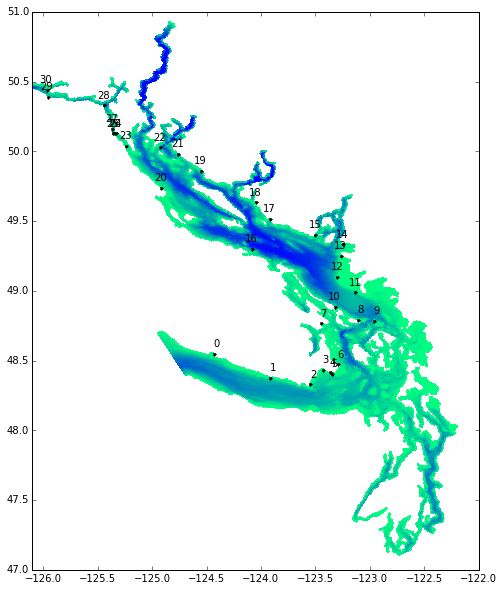

In [7]:
fig,ax=plt.subplots(1, 1, figsize=(8, 10))
ax.pcolormesh(X,Y,bathy,cmap='winter_r')

for stn in range(numsta):
    location = stations_obs[stn]
    lon=-harm_obs.lon[harm_obs.site==location]
    lat=harm_obs.lat[harm_obs.site==location]
    ax.plot(lon,lat,'.k',label=location)
    ax.annotate(stn, xy = (lon,lat), xytext = (5,5),ha = 'right', va = 'bottom',
        textcoords = 'offset points')
    print stn, location
    
ax.axis([-126.1,-122,47,51])

Note: Some day it would be worthwhile to place the numbers more carefully so that they don't overlap.

# Tidal Harmonics

We need a way of determing the amplitude and phase of M2/K1/O1/S2 from our model output. We will do this by fitting our model water levels to cosine curves with the known frequency of M2/K1/O1/S2.

In [8]:
#constants and fitting
# M2
M2freq = 28.984106 # degrees per hour
M2freq = M2freq*np.pi/180. # radians per hour
#K1
K1freq = 15.041069*np.pi/180.
#O1
O1freq = 13.943036*np.pi/180.
#S2
S2freq = 30.000002*np.pi/180.
#P1
P1freq = 14.958932*np.pi/180.
#N2
N2freq = 28.439730*np.pi/180.
#Q1
Q1freq = 13.398661*np.pi/180.
#K2
K2freq = 30.082138*np.pi/180.

# initial phase calculation
# our start is currently Oct 26, 2002
# data for phase output from bdytides.F90; found in ocean.output
K1ft = 1.050578
K1uvt = 296.314842
M2ft = 0.987843
M2uvt = 245.888564
O1ft = 1.081364
O1uvt = 312.950020
S2ft = 1.0
S2uvt = 0.0
P1ft = 1.0
P1uvt = 55.79460
N2ft = 0.98784
N2uvt = 353.570277
Q1ft = 1.081364
Q1uvt = 60.631733
K2ft = 1.114095
K2uvt = 52.129248

# for start of Apr 21, 2003
new = 'false'
if new == 'true':

    K1ft = 1.065505
    K1uvt = 111.481741
    M2ft = 0.982328
    M2uvt = 250.506179
    O1ft = 1.105495
    O1uvt = 142.040782
    S2ft = 1.000000  
    S2uvt = 0.000000
    P1ft = 1.000000
    P1uvt = 241.335269
    N2ft = 0.982328
    N2uvt = 205.684028
    Q1ft = 1.105495 
    Q1uvt = 97.218631
    K2ft = 1.159036 
    K2uvt = 42.361669




In [9]:
# function for fit
def double(x, M2amp, M2pha, K1amp, K1pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.))

In [10]:
# function for fitting 3 frequencies
def triple(x, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.)+
            O1amp*np.cos(O1freq*x-O1pha*np.pi/180.))

In [11]:
# function for fitting 4 frequencies
def quad(x, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.)+
            O1amp*np.cos(O1freq*x-O1pha*np.pi/180.)+
            S2amp*np.cos(S2freq*x-S2pha*np.pi/180.))

In [12]:
# function for fitting 6 frequencies
def sextuple(x, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha,
                 P1amp, P1pha, N2amp, N2pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.)+
            O1amp*np.cos(O1freq*x-O1pha*np.pi/180.)+
            S2amp*np.cos(S2freq*x-S2pha*np.pi/180.)+
            P1amp*np.cos(P1freq*x-P1pha*np.pi/180.)+
            N2amp*np.cos(N2freq*x-N2pha*np.pi/180.))

In [13]:
# function for fitting 8 frequencies
def octuple(x, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha,
                 P1amp, P1pha, N2amp, N2pha, Q1amp, Q1pha, K2amp, K2pha):
    return (M2amp*np.cos(M2freq*x-M2pha*np.pi/180.)+
            K1amp*np.cos(K1freq*x-K1pha*np.pi/180.)+
            O1amp*np.cos(O1freq*x-O1pha*np.pi/180.)+
            S2amp*np.cos(S2freq*x-S2pha*np.pi/180.)+
            P1amp*np.cos(P1freq*x-P1pha*np.pi/180.)+
            N2amp*np.cos(N2freq*x-N2pha*np.pi/180.)+
            Q1amp*np.cos(Q1freq*x-Q1pha*np.pi/180.)+
            K2amp*np.cos(K2freq*x-K2pha*np.pi/180.))

Now we can apply this fit to our model output.

PortRenfrew
Victoria
PointAtkinson
CampbellRiver


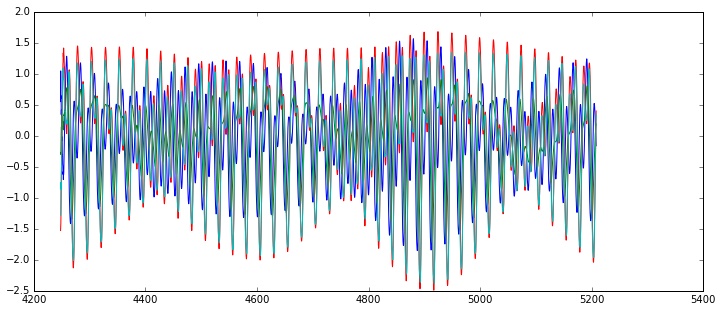

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
for stn in (0,4,14,23):
    print stations[stn]
    fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
    time = fT1.variables["time_counter"][:]/3600.  # want hours not seconds
    ssh = fT1.variables["sossheig"][:,0,0]
    ax.plot(time,ssh)

In [15]:
print ssh.shape
print 25*48*2, 30*24*4

(3840,)
2400 2880


In [16]:
#allocate space for our arrays
M2_amp=[]; M2_pha=[]; K1_amp=[]; K1_pha=[]
O1_amp=[]; O1_pha=[]; S2_amp=[]; S2_pha=[]
P1_amp=[]; P1_pha=[]; N2_amp=[]; N2_pha=[]
Q1_amp=[]; Q1_pha=[]; K2_amp=[]; K2_pha=[]

M2_amp_obs=np.zeros(numsta); M2_pha_obs=np.zeros(numsta)
K1_amp_obs=np.zeros(numsta); K1_pha_obs=np.zeros(numsta)
O1_amp_obs=np.zeros(numsta); O1_pha_obs=np.zeros(numsta)
S2_amp_obs=np.zeros(numsta); S2_pha_obs=np.zeros(numsta)
P1_amp_obs=np.zeros(numsta); P1_pha_obs=np.zeros(numsta)
N2_amp_obs=np.zeros(numsta); N2_pha_obs=np.zeros(numsta)
Q1_amp_obs=np.zeros(numsta); Q1_pha_obs=np.zeros(numsta)
K2_amp_obs=np.zeros(numsta); K2_pha_obs=np.zeros(numsta)

ts = 240
te = ssh.shape[0]

  
for stn in range(numsta):
    fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
    time = fT1.variables["time_counter"][:]/3600.  # want hours not seconds
    ssh = fT1.variables["sossheig"][:,0,0]

    fitted, cov = curve_fit(octuple,time[ts:te],ssh[ts:te]) 
    if fitted[0] < 0:
        fitted[0] = -fitted[0]
        fitted[1] = fitted[1]+180

    M2_amp.append(fitted[0]*M2ft)
    pha = fitted[1]+M2uvt
    if stn == 6:
        print pha
    M2_pha.append(angles.normalize(pha))

    if fitted[2] < 0:
        fitted[2] = - fitted[2]
        fitted[3] = fitted[3] + 180
    K1_amp.append(fitted[2]*K1ft)
    pha = fitted[3] + K1uvt
    K1_pha.append(angles.normalize(pha))  
    
    if fitted[4] < 0:
        fitted[4] = -fitted[4]
        fitted[5] = fitted[5]+180
    O1_amp.append(fitted[4]*O1ft)
    pha= fitted[5]+O1uvt
    O1_pha.append(angles.normalize(pha)) 
    
    if fitted[6] < 0:
        fitted[6] = -fitted[6]
        fitted[7] = fitted[7]+180
    S2_amp.append(fitted[6]*S2ft)
    S2_pha.append(angles.normalize(pha)) 
    
    if fitted[8] < 0:
            fitted[8] = -fitted[8]
            fitted[9] = fitted[9]+180
    P1_amp.append(fitted[8]*P1ft)
    pha= fitted[9]+P1uvt
    P1_pha.append(angles.normalize(pha)) 
    
    if fitted[10] < 0:
            fitted[10] = -fitted[10]
            fitted[11] = fitted[11]+180
    N2_amp.append(fitted[10]*N2ft)
    pha= fitted[11]+N2uvt
    N2_pha.append(angles.normalize(pha)) 
    
    if fitted[12] < 0:
            fitted[12] = -fitted[12]
            fitted[13] = fitted[13]+180
    Q1_amp.append(fitted[12]*Q1ft)
    pha= fitted[13]+Q1uvt
    Q1_pha.append(angles.normalize(pha))
    
    if fitted[14] < 0:
            fitted[14] = -fitted[14]
            fitted[15] = fitted[15]+180
    K2_amp.append(fitted[14]*K2ft)
    pha= fitted[15]+K2uvt
    K2_pha.append(angles.normalize(pha)) 

    #now the observations
    location=stations_obs[stn]
    M2_amp_obs[stn]=harm_obs.M2_amp[harm_obs.site==location]/100
    M2_pha_obs[stn]=harm_obs.M2_pha[harm_obs.site==location]
    K1_amp_obs[stn]=harm_obs.K1_amp[harm_obs.site==location]/100
    K1_pha_obs[stn]=harm_obs.K1_pha[harm_obs.site==location]
    
    #O1/S2/P1/N2/Q1/K2 are in the other file
    if (harm_other.site==location).any():
        O1_amp_obs[stn]=harm_other.O1_amp[harm_other.site==location]/100
        O1_pha_obs[stn]=harm_other.O1_pha[harm_other.site==location]
        S2_amp_obs[stn]=harm_other.S2_amp[harm_other.site==location]/100
        S2_pha_obs[stn]=harm_other.S2_pha[harm_other.site==location]
        P1_amp_obs[stn]=harm_other.P1_amp[harm_other.site==location]/100
        P1_pha_obs[stn]=harm_other.P1_pha[harm_other.site==location]
        N2_amp_obs[stn]=harm_other.N2_amp[harm_other.site==location]/100
        N2_pha_obs[stn]=harm_other.N2_pha[harm_other.site==location]
        Q1_amp_obs[stn]=harm_other.Q1_amp[harm_other.site==location]/100
        Q1_pha_obs[stn]=harm_other.Q1_pha[harm_other.site==location]
        K2_amp_obs[stn]=harm_other.K2_amp[harm_other.site==location]/100
        K2_pha_obs[stn]=harm_other.K2_pha[harm_other.site==location]
    #Mask the arrays so that we can do statistics without the 0's throwing thigns off.
    O1_amp_obs =np.ma.masked_values(O1_amp_obs, 0)
    O1_pha_obs =np.ma.masked_values(O1_pha_obs, 0)
    S2_amp_obs =np.ma.masked_values(S2_amp_obs, 0)
    S2_pha_obs =np.ma.masked_values(S2_pha_obs, 0)
    P1_amp_obs =np.ma.masked_values(P1_amp_obs, 0)
    P1_pha_obs =np.ma.masked_values(P1_pha_obs, 0)
    N2_amp_obs =np.ma.masked_values(N2_amp_obs, 0)
    N2_pha_obs =np.ma.masked_values(N2_pha_obs, 0)
    Q1_amp_obs =np.ma.masked_values(Q1_amp_obs, 0)
    Q1_pha_obs =np.ma.masked_values(Q1_pha_obs, 0)
    K2_amp_obs =np.ma.masked_values(K2_amp_obs, 0)
    K2_pha_obs =np.ma.masked_values(K2_pha_obs, 0)

-10.5426413097


The model data is saved in lists M2_amp, M2_pha, K1_amp, K1_pha. We have also saved the observations in M2_amp_obs, etc.

We can compare model and observations by plotting.

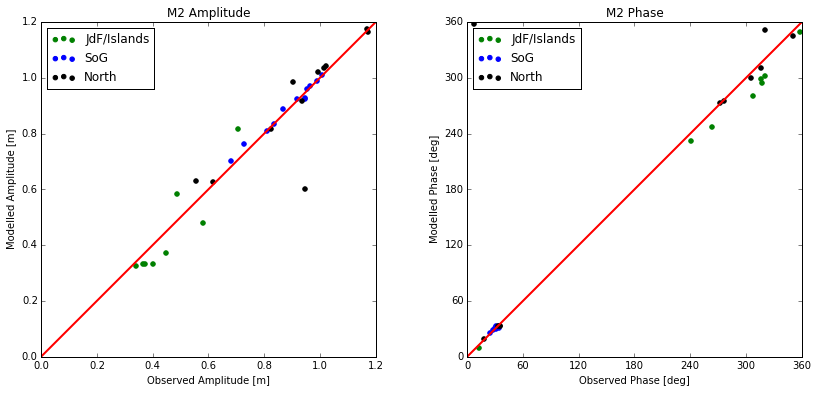

In [17]:
#Plotting M2
labels=['JdF/Islands','SoG','North']
split1=8; split2=20
fig=tidetools.plot_scatter_pha_amp(M2_amp,M2_amp_obs,M2_pha,M2_pha_obs,'M2',figsize=(14,6),
                                   split1=split1,split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)



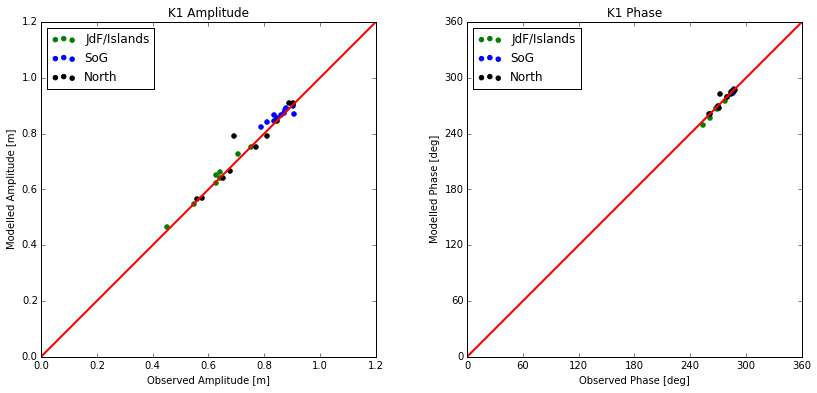

In [18]:
#Plotting - K1

fig=tidetools.plot_scatter_pha_amp(K1_amp,K1_amp_obs,K1_pha,K1_pha_obs,'K1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)



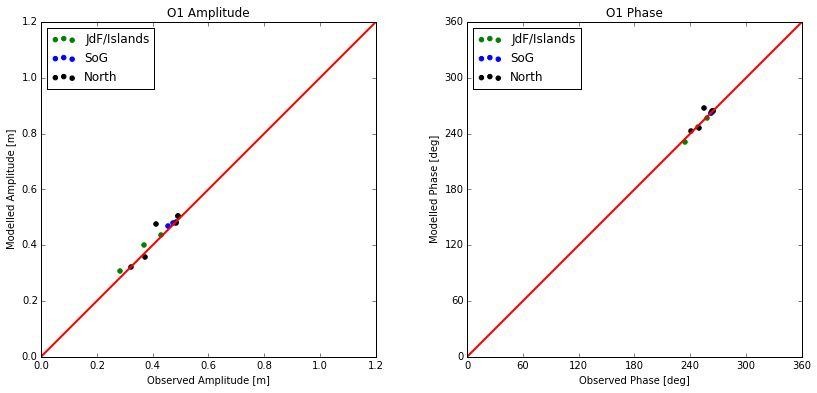

In [19]:
#Plotting - O1

fig=tidetools.plot_scatter_pha_amp(O1_amp,O1_amp_obs,O1_pha,O1_pha_obs,'O1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

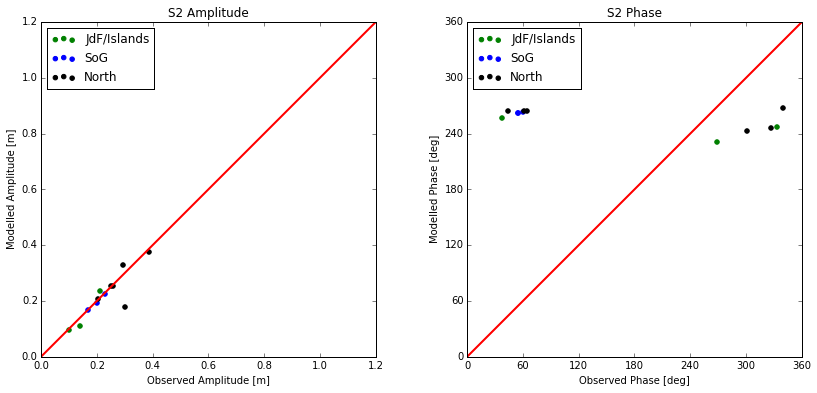

In [20]:
#Plotting - S2

fig=tidetools.plot_scatter_pha_amp(S2_amp,S2_amp_obs,S2_pha,S2_pha_obs,'S2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

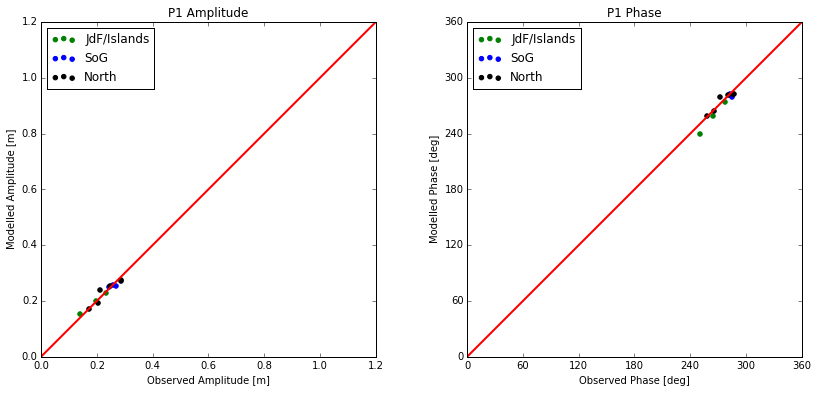

In [21]:
#Plotting - P1

fig=tidetools.plot_scatter_pha_amp(P1_amp,P1_amp_obs,P1_pha,P1_pha_obs,'P1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

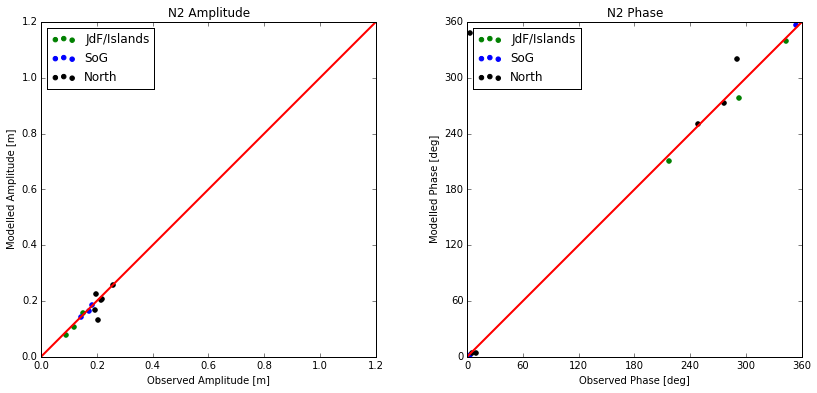

In [22]:
#Plotting - N2

fig=tidetools.plot_scatter_pha_amp(N2_amp,N2_amp_obs,N2_pha,N2_pha_obs,'N2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

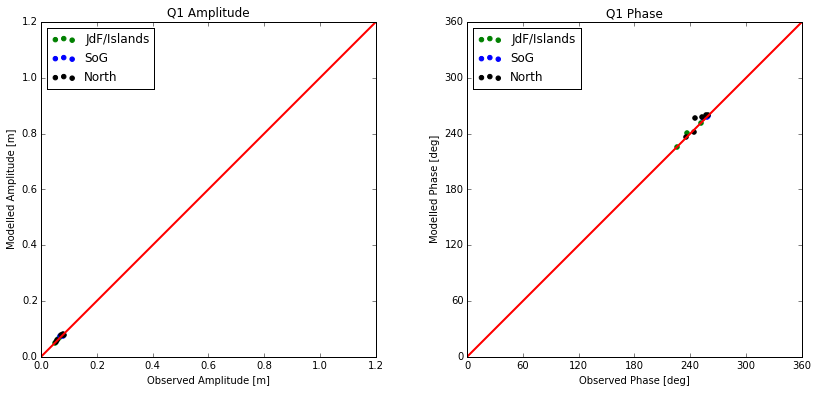

In [23]:
#Plotting - Q1

fig=tidetools.plot_scatter_pha_amp(Q1_amp,Q1_amp_obs,Q1_pha,Q1_pha_obs,'Q1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

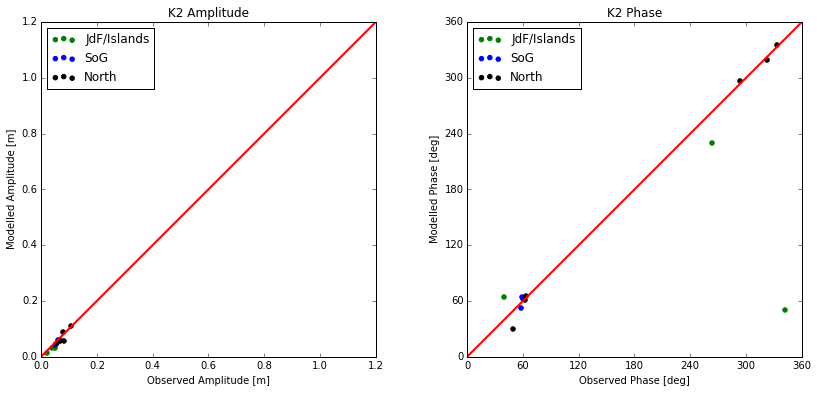

In [24]:
#Plotting - K2

fig=tidetools.plot_scatter_pha_amp(K2_amp,K2_amp_obs,K2_pha,K2_pha_obs,'K2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

The model performs well when the dots are close to the red line.

# Statistics

We would like to save some statistics so that we can determine which runs give us the best match with observations. So, we will define some functions that will help us calculate statistics.

### Mean Error (absolute value)

In [25]:
def mean(diff):
    return np.mean(abs(diff))

### RMS Error

In [26]:
def rms(diff):
    return np.sqrt(np.mean(diff**2))

### Complex differences

This is a way of measuring distances in the complex plane. We can think of our tidal amplitude and phase as a point on the complex plane. So we would like to measure the distance between a point given by the model and a point given by the observations. The function below does this.

In [27]:
def complex_diff(Ao,go,Am,gm):
    #calculates complex differences between observations and model
    #Ao, go - amplitude and phase from observations
    #Am, gm - amplitude and phase from model
    D = np.sqrt((Ao*np.cos(np.pi*go/180)-Am*np.cos(np.pi*gm/180))**2 + 
                (Ao*np.sin(np.pi*go/180)-Am*np.sin(np.pi*gm/180))**2)
    
    return D

Some other things we will look at are

$R = \frac{A_m}{A_o}$, the ratio of modelled to observed amplitude and 

$\Delta \phi = \phi_m - \phi_o$, the difference betwen modelled and observed phase.

In [28]:
#R
R_M2 = M2_amp/M2_amp_obs
R_K1 = K1_amp/K1_amp_obs
#delta phi (adjust so between -180, 180)
Dphi_M2 = M2_pha-M2_pha_obs; 
Dphi_M2 = Dphi_M2 -360*(Dphi_M2>180) + 360*(Dphi_M2<-180)
Dphi_K1 = K1_pha-K1_pha_obs
Dphi_K1 = Dphi_K1 -360*(Dphi_K1>180) + 360*(Dphi_K1<-180)
#Complex differences
D_M2= complex_diff(np.array(M2_amp_obs),np.array(M2_pha_obs), np.array(M2_amp),np.array(M2_pha))
D_K1= complex_diff(np.array(K1_amp_obs),np.array(K1_pha_obs), np.array(K1_amp),np.array(K1_pha))
D_O1= complex_diff(np.ma.array(O1_amp_obs),np.ma.array(O1_pha_obs), np.ma.array(O1_amp),np.ma.array(O1_pha))
D_S2= complex_diff(np.ma.array(S2_amp_obs),np.ma.array(S2_pha_obs), np.ma.array(S2_amp),np.ma.array(S2_pha))
D_P1= complex_diff(np.ma.array(P1_amp_obs),np.ma.array(P1_pha_obs), np.ma.array(P1_amp),np.ma.array(P1_pha))
D_N2= complex_diff(np.ma.array(N2_amp_obs),np.ma.array(N2_pha_obs), np.ma.array(N2_amp),np.ma.array(N2_pha))
D_Q1= complex_diff(np.ma.array(Q1_amp_obs),np.ma.array(Q1_pha_obs), np.ma.array(Q1_amp),np.ma.array(Q1_pha))
D_K2= complex_diff(np.ma.array(K2_amp_obs),np.ma.array(K2_pha_obs), np.ma.array(K2_amp),np.ma.array(K2_pha))

# Saving the results

We will now save these statistics in a spreadsheet

In [29]:
outfile = runname+'.csv'

with open(outfile, 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow([
            'Station Name', 
            'M2 Amp', 'M2 Pha', 'K1 Amp', 'K1 Pha',
            'S2 Amp', 'S2 Pha', 'O1 Amp', 'O1 Pha',
            'N2 Amp', 'N2 Pha', 'Q1 Amp', 'Q1 Pha',
            'K2 Amp', 'K2 Pha', 'P1 Amp', 'P1 Pha',
        ])
    for stn in range(numsta):
        location = stations_obs[stn]
        writer.writerow([stations_obs[stn],
                        M2_amp[stn], M2_pha[stn], K1_amp[stn], K1_pha[stn],
                        S2_amp[stn], S2_pha[stn], O1_amp[stn], O1_pha[stn],
                        N2_amp[stn], N2_pha[stn], Q1_amp[stn], Q1_pha[stn],
                        K2_amp[stn], K2_pha[stn], P1_amp[stn], P1_pha[stn]])


# Plots comparing measured and model amplitudes and phases

# Comparing corr15 and isoneutral

In [30]:
isoneutral = pd.read_csv('/data/nsoontie/MEOPAR/analysis/Nancy/tides/isoneutral.csv')
#tides_test2 = pd.read_csv('/ocean/imachuca/MEOPAR/analysis/Idalia/tides_test2.csv')
corr15 = pd.read_csv('/data/nsoontie/MEOPAR/analysis/Nancy/tides/corr15.csv')


Some other things we will look at are

$R = \frac{A_m}{A_o}$, the ratio of modelled to observed amplitude and 

$\Delta \phi = \phi_m - \phi_o$, the difference betwen modelled and observed phase.

D is complex difference

M2
Mean/max/min diff complex difference: 0.0007647 / 0.008926 / -0.01068
Mean/max/min diff amplitude: 0.001836 / 0.005748 / -0.008918
Mean/max/min diff phase: -0.09658 / 0.9881 / -0.8956
S2
Mean/max/min diff complex difference: 0.0005644 / 0.002551 / -0.00165
Mean/max/min diff amplitude: 0.0004531 / 0.002266 / -0.001612
Mean/max/min diff phase: -0.07757 / 0.2122 / -0.2979
N2
Mean/max/min diff complex difference: -4.763e-05 / 0.001913 / -0.002195
Mean/max/min diff amplitude: 0.0003462 / 0.001238 / -0.001774
Mean/max/min diff phase: -0.1013 / 0.7306 / -0.866
K2
Mean/max/min diff complex difference: 0.0002436 / 0.00141 / -0.001045
Mean/max/min diff amplitude: 0.0005673 / 0.001663 / -0.0005709
Mean/max/min diff phase: 0.3194 / 4.378 / -1.383
K1
Mean/max/min diff complex difference: 0.0001221 / 0.003412 / -0.004434
Mean/max/min diff amplitude: 0.001566 / 0.002645 / 6.432e-05
Mean/max/min diff phase: -0.0833 / 0.2865 / -0.3018
O1
Mean/max/min diff complex difference: 0.0002887 / 0.001156 / -

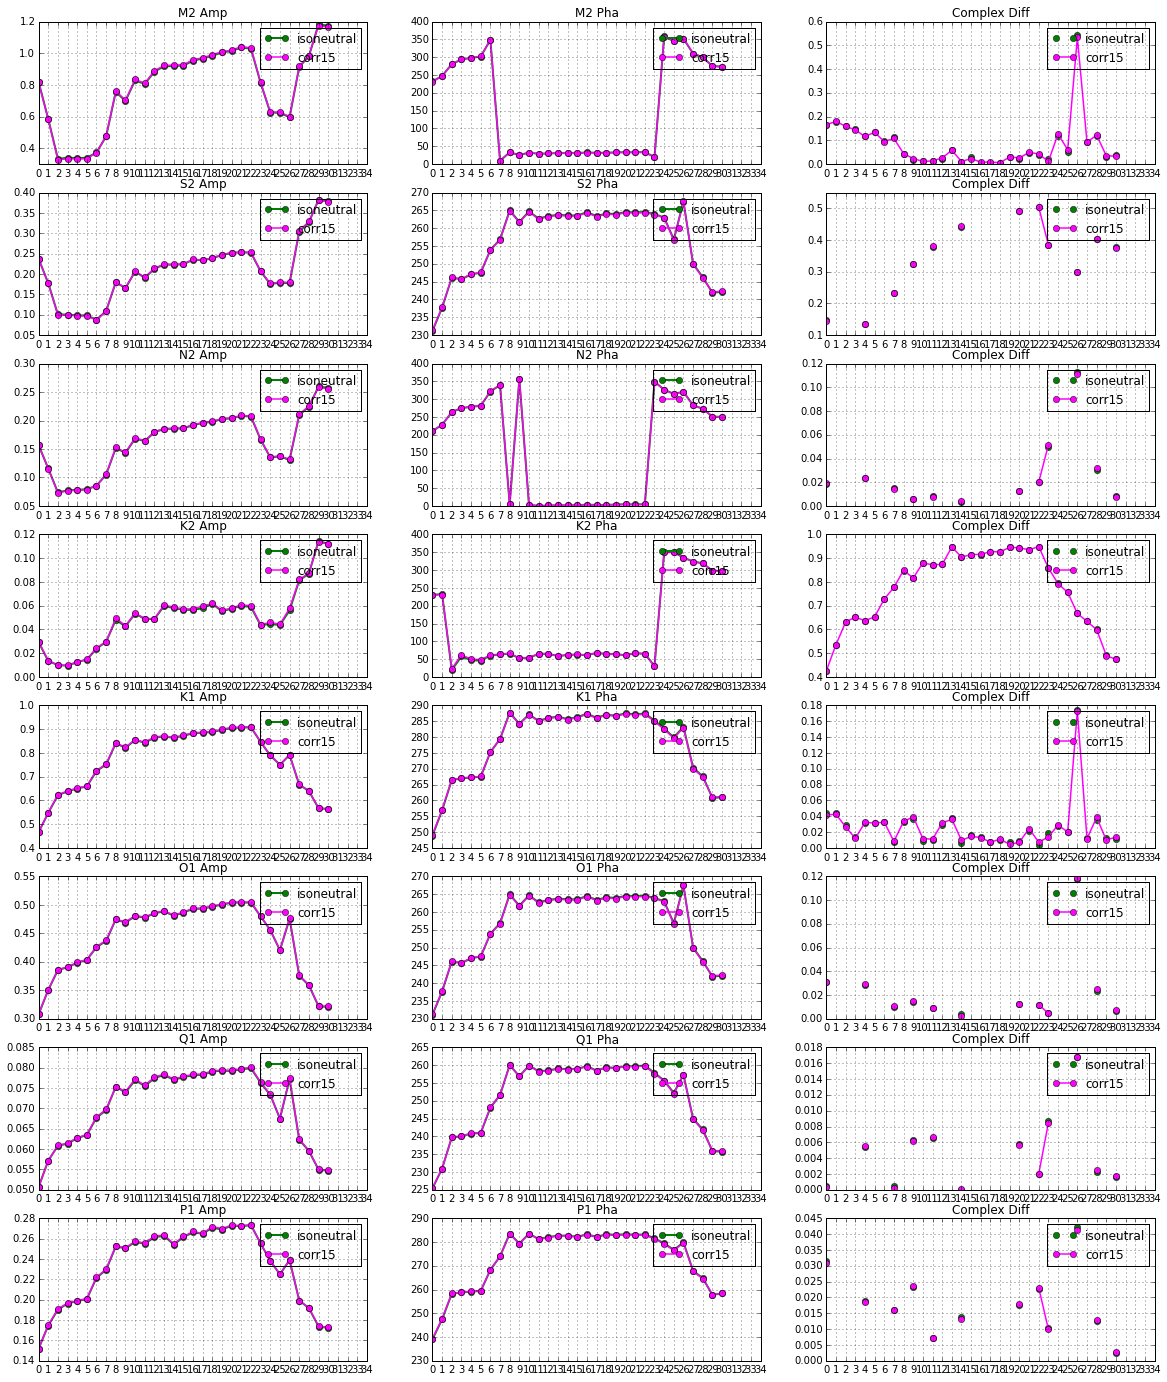

In [31]:
vars_amp=['M2 Amp', 'S2 Amp', 'N2 Amp', 'K2 Amp',
          'K1 Amp', 'O1 Amp', 'Q1 Amp', 'P1 Amp']
vars_pha=['M2 Pha', 'S2 Pha', 'N2 Pha', 'K2 Pha',
          'K1 Pha', 'O1 Pha', 'Q1 Pha', 'P1 Pha']
obs_amp = [M2_amp_obs, S2_amp_obs, N2_amp_obs, K1_amp_obs,
           K1_amp_obs, O1_amp_obs, Q1_amp_obs, P1_amp_obs]
obs_pha = [M2_pha_obs, S2_pha_obs, N2_pha_obs, K1_pha_obs,
           K1_pha_obs, O1_pha_obs, Q1_pha_obs, P1_pha_obs]
cols=np.arange(len(vars_amp))
fig,axs = plt.subplots(8,3,figsize=(20,24))
for col, var in zip(cols, vars_amp):
    ax=axs[col,0]
    ax.plot(isoneutral[var], '-og', label='isoneutral', linewidth=2)
    ax.plot(corr15[var], 'Magenta', marker='o',ls='-',label='corr15', linewidth=1.5)
    #axs[col].plot(tides_test2[var], 'OrangeRed', label='tides_test2', linewidth=1.5)
    ax.legend()
    ax.set_title(var)
    ax.xaxis.set_ticks(np.arange(0, 35, 1))
    ax.grid()
for col, var in zip(cols, vars_pha):
    ax=axs[col,1]
    ax.plot(isoneutral[var], '-og', label='isoneutral', linewidth=2)
    ax.plot(corr15[var], 'Magenta',marker='o',ls='-', label='corr15', linewidth=1.5)
    #axs[col].plot(tides_test2[var], 'OrangeRed', label='tides_test2', linewidth=1.5)
    ax.legend()
    ax.set_title(var)
    ax.xaxis.set_ticks(np.arange(0, 35, 1))
    ax.grid()
for col, amp, pha, oamp, opha in zip(cols, vars_amp, vars_pha, obs_amp, obs_pha):
    ax=axs[col,2]
    iso_diff = complex_diff(np.ma.array(oamp),np.ma.array(opha), np.array(isoneutral[amp]),np.array(isoneutral[pha]))
    ax.plot(iso_diff, 'go', label='isoneutral', linewidth=2)
    corr_diff = complex_diff(np.ma.array(oamp),np.ma.array(opha),np.array(corr15[amp]),np.array(corr15[pha]))
    ax.plot(corr_diff, 'Magenta',marker='o',label='corr15', linewidth=1.5)
    #axs[col].plot(tides_test2[var], 'OrangeRed', label='tides_test2', linewidth=1.5)
    ax.legend()
    ax.set_title('Complex Diff')
    ax.xaxis.set_ticks(np.arange(0, 35, 1))
    ax.grid()
    
    print '{}'.format(amp[0:2])
    print 'Mean/max/min diff complex difference: {0:.4} / {1:.4} / {2:.4}'.format(np.mean(corr_diff - iso_diff),
                                                                                   np.max(corr_diff - iso_diff),
                                                                                   np.min(corr_diff - iso_diff))
    
    
    print 'Mean/max/min diff amplitude: {0:.4} / {1:.4} / {2:.4}'.format(np.mean(corr15[amp] - isoneutral[amp]),
                                                                          np.max(corr15[amp] - isoneutral[amp]),
                                                                          np.min(corr15[amp] - isoneutral[amp]))
    
    print 'Mean/max/min diff phase: {0:.4} / {1:.4} / {2:.4}'.format(np.mean(corr15[pha] - isoneutral[pha]),
                                                                          np.max(corr15[pha] - isoneutral[pha]),
                                                                          np.min(corr15[pha] - isoneutral[pha]))

#Summary
* Changes in the complex differences are minimal (no more than 2 decimal places or ~1 cm) 
* Changes in the ampltiude are minimal ( no more than 3 decimal places or  ~8 mm)
* Changes in the phase are minimal ( no more than 4 degrees in K2, or 1 deg for the other constituents)